# Making question

#### Các thư viện cần thiết

In [ ]:
import requests
import json
import pandas as pd
import numpy as np
import time
import datetime
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings
warnings.filterwarnings("ignore") # bỏ qua tất cả các cảnh báo
pd.set_option('display.max_columns', None) # hiển thị hết các cột

Đọc dữ liệu từ các file csv đã được làm sạch

In [41]:
match_overview_df = pd.read_csv('./data/clean_data/match_overview.csv', delimiter='\t')
match_statistics_df = pd.read_csv('./data/clean_data/match_statistics.csv', delimiter='\t')
team_ranking_df = pd.read_csv('./data/clean_data/team_rankings.csv', delimiter=',')
team_profile_df = pd.read_csv('./data/clean_data/team_profile.csv', delimiter=',')

## Câu hỏi 1: Mối liên hệ giữa tổng giá trị thị trường và thứ hạng đội bóng?

**Ý nghĩa của câu hỏi:**  
Trả lời câu hỏi này sẽ giúp chúng ta:  
- Hiểu rõ mức độ ảnh hưởng của tổng giá trị thị trường đến thứ hạng của các đội bóng.  
- Xác định xem liệu giá trị tài chính có phải là yếu tố quyết định đến thành tích trên bảng xếp hạng.

**Các DataFrame được sử dụng để phân tích:**  
- `team_ranking_df`: Chứa dữ liệu về thứ hạng của các đội bóng.  
- `team_profile_df`: Chứa thông tin chi tiết, bao gồm giá trị thị trường của các đội bóng.  

Merge 2 dataFrame trên lại theo cột `Season` và `Team`

In [85]:
team_profile_df.rename(columns={'Club': 'Team'}, inplace=True)
Q1_merged_df = pd.merge(team_ranking_df, team_profile_df, on=['Season', 'Team'], how='inner')

**Ta sẽ trả lời câu hỏi này bằng cách**: phân tích tổng thể, thông qua việc quan sát giá trị trung bình của `Total market value` và thứ hạng trung bình (`Ranking`) của từng đội bóng qua tất cả các mùa giải mà đội bóng đó tham gia.

In [101]:
Q1_team_avg_stats = Q1_merged_df.groupby('Team')[['Total market value', 'Ranking']].mean().reset_index()

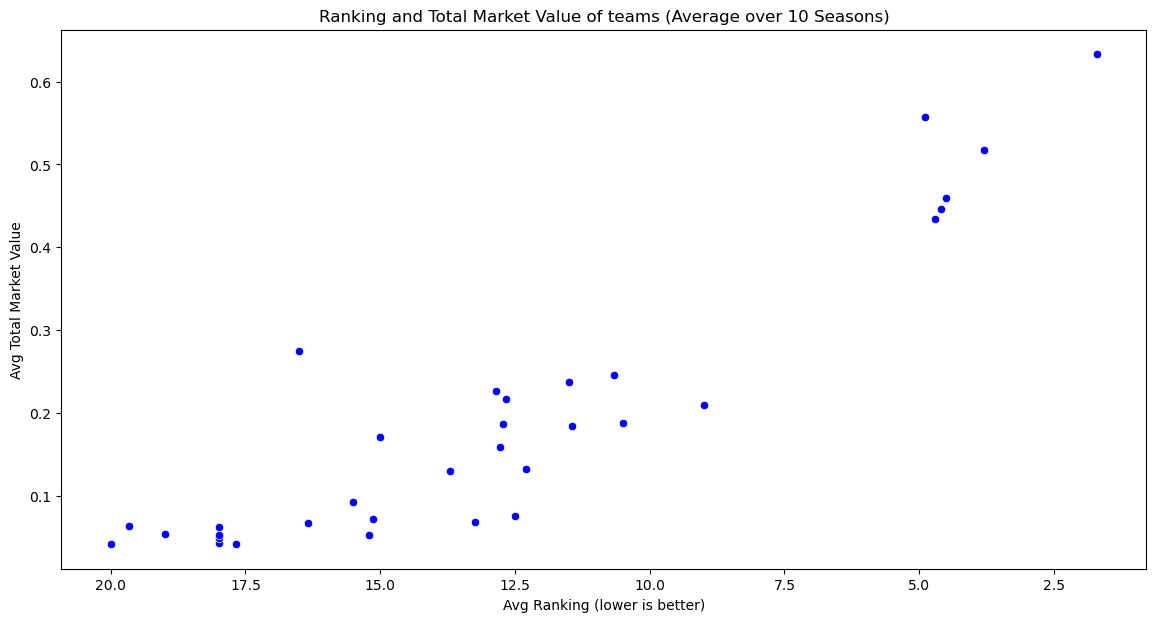

In [164]:
plt.figure(figsize=(14, 7))
scatter_plot = sns.scatterplot(x='Ranking', y='Total market value', data=Q1_team_avg_stats, color='blue')
plt.title('Ranking and Total Market Value of teams (Average over 10 Seasons)')
plt.xlabel('Avg Ranking (lower is better)')
plt.ylabel('Avg Total Market Value')
plt.gca().invert_xaxis()
plt.show()

**Nhận xét**
- Như vậy từ biểu đồ trên, có thể thấy có một xu hướng là các đội bóng có thứ hạng cao sẽ có giá trị thị trường (`Total market value`) cao hơn, điều này cũng đúng với các đội có thứ hạng thấp với giá trị thị trường thấp hơn.
- .....
- .....

## Câu hỏi 2: Tỷ lệ thắng của các trận đấu khi diễn ra trên sân nhà và trên sân khách qua từng mùa giải như thế nào? Và trung bình cho tất cả mùa giải?

**Ý nghĩa của câu hỏi:**  
Trả lời câu hỏi này sẽ giúp chúng ta:
- Hiểu được sự khác biệt về tỷ lệ thắng của các đội bóng khi chơi trên sân nhà và sân khách qua các mùa giải.
- Đánh giá ảnh hưởng của yếu tố sân bãi đến kết quả thi đấu của các đội bóng.

**Các DataFrame được sử dụng để phân tích:**  
- `match_overview.csv`: Chứa dữ liệu về các trận đấu, bao gồm thông tin đội nhà, đội khách, và kết quả trận đấu.

#### 2.1 Đầu tiên ta sẽ xem xét tỉ lệ thắng trên trân nhà và sân khách của từng mùa giải

In [171]:
Q2_data = match_overview_df[['Match ID', 'Season', 'Home Team', 'Away Team', 'Winner']]
Q2_data['Match Results'] = np.select([
        Q2_data['Winner'] == 'Draw',  # 2 nếu kết quả là hòa
        Q2_data['Home Team'] == Q2_data['Winner'],  # 1 nếu đội chủ nhà thắng
        Q2_data['Away Team'] == Q2_data['Winner']  # 0 nếu đội khách thắng
    ], [2, 1, 0], default=np.nan )

In [172]:
season_match_summary = Q2_data.groupby('Season')['Match Results'].value_counts().unstack(fill_value=0)
season_match_summary.columns = ['Away Wins', 'Home Wins', 'Draw']  
season_match_summary['Total Matches'] = season_match_summary.sum(axis=1)  
season_match_summary['% Home Wins'] = season_match_summary['Home Wins'] / season_match_summary['Total Matches'] * 100
season_match_summary['% Away Wins'] = season_match_summary['Away Wins'] / season_match_summary['Total Matches'] * 100

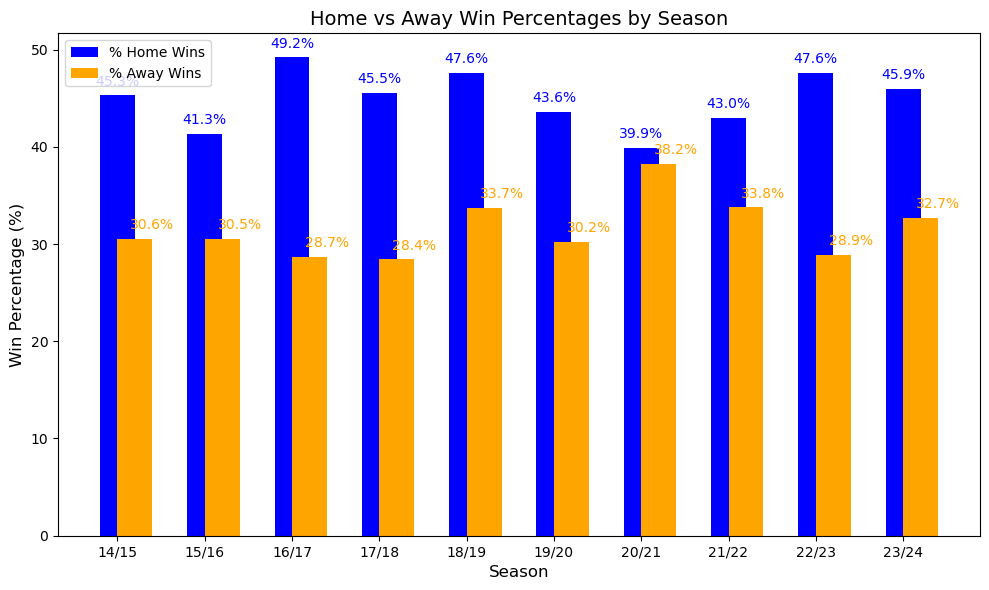

In [173]:
seasons = season_match_summary.index
home_win_ratio = season_match_summary['% Home Wins'] 
away_win_ratio = season_match_summary['% Away Wins'] 
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(seasons, home_win_ratio, width=0.4, label='% Home Wins', color='blue', align='center')
ax.bar(seasons, season_match_summary['% Away Wins'], width=0.4, label='% Away Wins', color='orange', align='edge')
ax.set_xlabel('Season', fontsize=12)
ax.set_ylabel('Win Percentage (%)', fontsize=12)
ax.set_title('Home vs Away Win Percentages by Season', fontsize=14)
ax.legend()

for i in range(len(seasons)):
    ax.text(i, home_win_ratio.iloc[i] + 1, f"{home_win_ratio.iloc[i]:.1f}%", ha='center', color='blue')
    ax.text(i + 0.4, away_win_ratio.iloc[i] + 1, f"{away_win_ratio.iloc[i]:.1f}%", ha='center', color='orange')
    
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### 2.2 Cuối cùng là tỉ lệ thắng trên trân nhà và sân khách trung bình của tất cả mùa giải

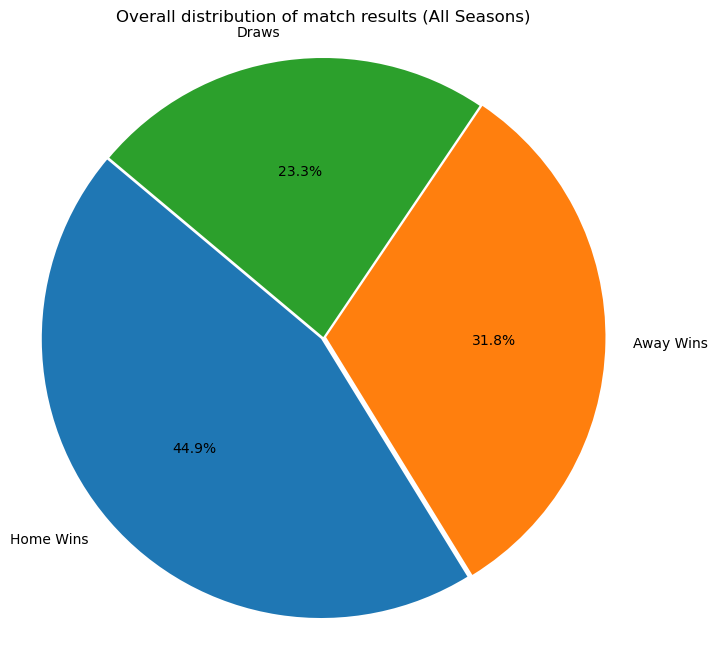

In [174]:
labels = ['Home Wins', 'Away Wins', 'Draws']
sizes = [season_match_summary['Home Wins'].sum(), season_match_summary['Away Wins'].sum(), season_match_summary['Draw'].sum()]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
explode = (0.01, 0.01, 0)  
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)
plt.title('Overall distribution of match results (All Seasons)')
plt.axis('equal')
plt.show()

**Nhận xét**:
- Từ hai biểu đồ trên, có thể thấy rằng đội nhà có tỷ lệ thắng cao hơn so với đội khách qua các mùa giải gần đây.
- Các lý do có thể như khi thi đấu trên sân nhà, các cầu thủ thường sữ nhận được sự ủng hộ nhiều hơn từ khán giả, giúp nâng cao tinh thần thi đấu và sự tự tin, ngược lại các đội khách khi thi đấu chịu phải sự cổ vũ của khán giả đội nhà có thể bị gây áp lực về tinh thần. Và bởi vì là đội chủ nhà nên sẽ quen thuộc với điều kiện sân bãi, thời tiết, giúp họ dễ dàng triển khai chiến thuật hơn.
- Tuy nhiên, tỷ lệ hòa vẫn chiếm một phần đáng kể, cho thấy rằng nhiều trận đấu có sự cân bằng về trình độ và chiến thuật giữa hai đội.